In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter
import random
import decimal
import math
import random
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
##------------------------------Pegando os Dados-----------------------------------

#url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-12-21/2019-03-21/A307"
url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-01-01/2019-12-31/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
df_temp = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    df.dropna(inplace=True)
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED']]
    df_temp["id"] = df.index + 1 

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    #df_umid["id"] = df.index + 1

<ipython-input-2-4c0a7404db43>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["id"] = df.index + 1


In [3]:

df_training_temp = None
df_training_temp_anomalie_edit = None
desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalTemp = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'TEMP_MAX')
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalUmid = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'UMID_MED')
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

'''
[-0.91793819 -0.34818345  0.28487737  0.47479561 -0.6963669   2.27901894
 -1.20281555 -1.10785643  0.          0.47479561 -0.03165304 -0.41148953
 -1.29777468 -1.3927338   0.79132602 -0.8546321   0.79132602  0.91793819
 -0.25322433 -0.06330608  0.72801994 -0.79132602  0.31653041  0.94959123
  0.28487737  1.61430508 -0.53810169  0.72801994 -1.70926421  1.77257029]
'''

def extrairErro(dataframe, coluna):
    train_size = int(dataframe.shape[0] * 1)
    train_Real, train_Pred = dataframe.to_numpy()[:,0], dataframe.to_numpy()[:,1]
    train_resid = [train_Real[i]-train_Pred[i] for i in range(len(dataframe))]
    desvioErro = np.std(train_resid)
    return desvioErro

def TransformarEmEstacionaria(df_training_temp):
    converterColunasToFloat(df_training_temp, "TEMP_MAX")
    converterColunasToFloat(df_training_temp, "UMID_MED")

    df_training_temp['UMID_MED'] = df_training_temp['UMID_MED'].diff()
    df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].diff()
    df_training_temp.dropna()
    return df_training_temp

def equacaoExponencial():
    numberX = decimal.Decimal(random.randrange(-50, 50))/100
    eq = math.exp((3 * abs(numberX))) + 3
    return float(eq)

def converterColunasToFloat(dataframe, coluna):
    dataframe[coluna] = dataframe[coluna].astype(float)
    dataframe[coluna].apply(lambda x: float(x))
    return dataframe


def autoReg(dataframe_anomalies_edit):
    ar_model = AutoReg(np.array(dataframe_anomalies_edit), trend='n', lags=1).fit()
    pred = ar_model.predict(start=0,end= dataframe_anomalies_edit.shape[0], dynamic=False)
    return pred

In [4]:
#------------------------------Tratando os Dados-----------------------------------

dfAnomaliasFinal =  pd.DataFrame()

def dataTraining(percentOutliers, dbscan):
    
    qtd_training_temp = int(qtdRowsTemp()/3) * 2

    if dbscan:
        qtd_training_temp = qtdRowsTemp()

    df_training_temp = df_temp.sample(qtd_training_temp)

    df_training_temp = TransformarEmEstacionaria(df_training_temp) #Série Estacionária

    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)    
    df_training_temp_anomalie_edit = df_training_temp.sample(n=count_training_temp)
    
    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")

    equacaoExpo = equacaoExponencial()
    
    temperaturas = autoReg(df_training_temp_anomalie_edit['TEMP_MAX']) #AutoRegressão
    umidades = autoReg(df_training_temp_anomalie_edit['UMID_MED']) #AutoRegressão
    
    df_ids = np.array(df_training_temp_anomalie_edit['id'])
    
    df_temp_real_pred = pd.DataFrame()
    colTemp = ['temp_real','temp_pred']
    df_temp_real_pred = pd.DataFrame(columns=colTemp)
    df_temp_real_pred['temp_real'] = df_training_temp_anomalie_edit['TEMP_MAX']
    df_temp_real_pred['temp_pred'] = temperaturas.tolist()

    df_umid_real_pred = pd.DataFrame()
    col_umid = ['umid_real','umid_pred']
    df_umid_real_pred = pd.DataFrame(columns=col_umid)
    df_umid_real_pred['umid_real'] = df_training_temp_anomalie_edit['UMID_MED']
    df_umid_real_pred['umid_pred'] = umidades.tolist()
    
    valorFinalTemp = valorFinalTemperatura(df_temp_real_pred, True, equacaoExpo)
    valorFinalUmid = valorFinalUmidade(df_umid_real_pred, True, equacaoExpo)
    
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")

    dfAnomalias = pd.DataFrame()
    col = ['TEMP_MAX','UMID_MED', 'id']

    dfAnomalias = pd.DataFrame(columns=col)

    df_training_temp_anomalie_edit.sort_index(inplace=True)

    for index, row in df_training_temp_anomalie_edit.iterrows():
        temp = row['TEMP_MAX'] + (np.sign(row['TEMP_MAX']) * valorFinalTemp)
        umid = row['UMID_MED'] + (np.sign(row['UMID_MED']) * valorFinalUmid)
        x = np.array([[temp, umid, row['id']]], np.float)
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'id'])
        
        df1.set_index('id',inplace=True)

        dfAnomalias = pd.concat([df1, dfAnomalias])
        
    dfAnomalias = dfAnomalias.drop(columns='id')
        
    dfAnomalias.sort_index(inplace=True)    

    print ('Anomalias: ')
    print (dfAnomalias)
    dfFinal = dfAnomalias

    for index, row in df_training_temp.iterrows():
        x = np.array([[row['TEMP_MAX'], row['UMID_MED'], row['id']]], np.float)
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'id'])
        
        df1.set_index('id',inplace=True)
        
        dfFinal = pd.concat([df1, dfFinal])

    dfFinal.sort_index(inplace=True)    
    df_training_temp = dfFinal
    df_training_temp.dropna(inplace=True)

    dfAnomalias.sort_index(inplace=True)
 
    #Treino
    df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
    df_training_temp = converterColunasToFloat(df_training_temp, "UMID_MED")
    
    df_training_temp.dropna(inplace=True)
    df_training_temp.sort_index(inplace=True)

    #Teste
    count_test_temp = int((df_test_temp.shape[0] * percentOutliers) / 100)
    df_test_temp_anomalie_edit = df_test_temp.sample(n=count_test_temp, random_state=1)
    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_test_temp_anomalie_edit.dropna(inplace=True)
    
    #df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].astype(float)
    #df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].astype(float)
    
    #valorFinalTemp = valorFinalTemperatura(df_test_temp_anomalie_edit, False, equacaoExpo)
    #valorFinalUmid = valorFinalUmidade(df_test_temp_anomalie_edit, False, equacaoExpo)
    
    #df_test_temp_anomalie_edit["TEMP_MAX"] = df_test_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
    #df_test_temp_anomalie_edit["UMID_MED"] = df_test_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)

    df_test_temp = pd.concat([df_test_temp, df_test_temp_anomalie_edit])
    
    df_test_temp["TEMP_MAX"] = df_test_temp["TEMP_MAX"].astype(float)
    df_test_temp["UMID_MED"] = df_test_temp["UMID_MED"].astype(float)
    
    df_test_temp = converterColunasToFloat(df_test_temp, "TEMP_MAX")
    df_test_temp = converterColunasToFloat(df_test_temp, "UMID_MED")
    
    df_test_temp.sort_index(inplace=True)

    df_test_temp.dropna(inplace=True)
    df_test_temp = df_test_temp.drop(columns='id')
    desvioPadrao = (desvioPadraoTempTraining + desvioPadraoUmidTraining) / 2
    return df_training_temp, df_test_temp, dfAnomalias

In [5]:
#import random

taxaContaminacao = 5
dfs = dataTraining(taxaContaminacao, True)
df_training_temp = dfs[0]
df_test_temp = dfs[1]
dfAnomalias = dfs[2]
print (dfAnomalias.shape)
df_training_temp = df_training_temp[df_training_temp.index.notnull()]
#print ()
#print (df_training_temp.head(n=100).to_string(index=True))

/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Anomalias: 
        TEMP_MAX   UMID_MED
12.0  -16.009697  54.624972
29.0   19.509697 -54.924972
33.0   13.909697  56.624972
38.0  -15.009697  71.324972
40.0   15.109697  64.924972
49.0  -14.109697  62.824972
61.0   13.409697  61.224972
201.0  13.609697 -62.324972
207.0 -14.909697 -63.924972
210.0 -16.309697 -64.524972
230.0  13.909697 -51.824972
233.0 -16.409697  58.724972
258.0  13.409697 -55.524972
279.0  13.609697 -55.024972
333.0  16.109697 -61.924972
340.0 -19.309697  82.424972
346.0 -14.509697  54.924972
388.0  16.009697 -53.024972
448.0 -17.409697  73.224972
449.0 -19.209697  86.224972
462.0 -13.809697  60.924972
479.0  14.409697 -62.624972
503.0  15.309697  51.824972
533.0 -14.609697  60.924972
562.0  13.409697  53.824972
580.0  13.209697 -66.524972
602.0  13.509697 -55.524972
622.0  13.509697 -67.324972
678.0  15.809697 -60.224972
(29, 2)


        TEMP_MAX   UMID_MED
12.0  -16.009697  54.624972
29.0   19.509697 -54.924972
33.0   13.909697  56.624972
38.0  -15.009697  71.324972
40.0   15.109697  64.924972
41.0   -6.500000  39.600000
49.0  -14.109697  62.824972
61.0   13.409697  61.224972
201.0  13.609697 -62.324972
207.0 -14.909697 -63.924972
210.0 -16.309697 -64.524972
230.0  13.909697 -51.824972
233.0 -16.409697  58.724972
258.0  13.409697 -55.524972
279.0  13.609697 -55.024972
302.0   4.700000  16.700000
333.0  16.109697 -61.924972
338.0 -10.100000  37.000000
340.0 -19.309697  82.424972
346.0 -14.509697  54.924972
388.0  16.009697 -53.024972
448.0 -17.409697  73.224972
449.0 -19.209697  86.224972
462.0 -13.809697  60.924972
479.0  14.409697 -62.624972
503.0  15.309697  51.824972
533.0 -14.609697  60.924972
562.0  13.409697  53.824972
566.0 -11.000000  21.400000
580.0  13.209697 -66.524972
602.0  13.509697 -55.524972
622.0  13.509697 -67.324972
678.0  15.809697 -60.224972
688.0   9.300000 -38.100000


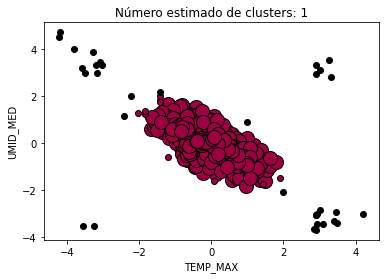

(5, 2)


In [7]:
#------------------------------Implementando o DBSCAN-----------------------------------
def dbscan_part1(df_used, eps, min_samples):
    #X = np.array([ [1, 2], [2, 2], [7, 6], [28, 7], [2, 3], [25, 8], [3, 2],[1, 3],[1.1, 2],[1.2, 2],[1.3, 2],[1.4, 2]])
    X = np.array(df_used)
    X = StandardScaler().fit_transform(df_used)
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='auto').fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_

    outliers = df_used[db.labels_ == -1]

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Preto usado para ruído
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    outliers = outliers[outliers.index.notnull()]
    
    #print('Outliers encontrados: ')
    #print (outliers.shape)
    print (outliers)

    plt.title('Número estimado de clusters: %d' % n_clusters_)
    plt.xlabel("TEMP_MAX")
    plt.ylabel("UMID_MED")
    plt.show()
    return outliers

eps = 0.5
min_samples = 10
#x = np.array([[10, 50], [12, 50], [48, 70]], np.float)
df_training_temp = df_training_temp[df_training_temp.index.notnull()]
#print (df_training_temp.shape[0])
#print(df_training_temp.head(n=50).to_string(index=True))

outliers = dbscan_part1(df_training_temp, eps, min_samples)
dfOutliersErrados = pd.concat([outliers, dfAnomalias]).drop_duplicates(keep=False)
print (dfOutliersErrados.shape)

In [12]:
print (2200/30)

73.33333333333333


(11, 2)


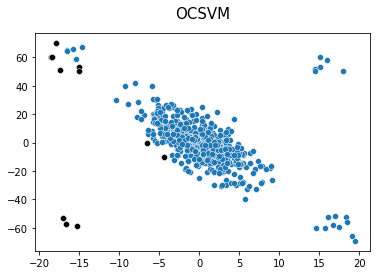

In [72]:
from sklearn.svm import OneClassSVM
import seaborn as sns

#x = np.array([[10, 50], [12, 50]], np.float)
#df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
#df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)

X = np.array(df_training_temp)
#X, _ = make_blobs(n_samples=df_training_temp.shape[0], centers=X, cluster_std=0.4,random_state=None)

ocsvm = OneClassSVM(kernel='linear', gamma='scale', nu=0.1, coef0=0.0,tol=0.001,
                    shrinking=True,cache_size=200,
                    verbose=False,max_iter=-1)

pred = ocsvm.fit_predict(X)

outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

dfAnomaliesOCSVM = pd.DataFrame(outlier_values, 
             columns=['TEMP_MAX', 
                      'UMID_MED'])
print (dfAnomaliesOCSVM.shape)

sns.scatterplot(x=X[:,0], y=X[:,1])
sns.scatterplot(x=outlier_values[:,0], 
                y=outlier_values[:,1], color='black')
plt.title("OCSVM", fontsize=15, pad=15)
plt.savefig("One-Class SVM Detection.png", dpi=80)

        TEMP_MAX   UMID_MED
1.0     2.000000  -2.300000
2.0     3.900000  -6.200000
3.0     2.000000   4.200000
4.0    -1.400000  22.000000
5.0    -7.600000  28.400000
...          ...        ...
726.0   4.800000 -14.800000
727.0  -4.600000   0.600000
728.0  -0.900000   2.500000
729.0  14.453484  50.137809
730.0  -5.300000  13.800000

[611 rows x 2 columns]
    TEMP_MAX  UMID_MED
0   3.117504  2.989116
1  -3.693057  3.930823
2  -3.589889  2.859420
3  -3.837493  3.400761
4  -3.445453 -3.246202
5  -3.796226  3.372566
6   3.488911 -2.930420
7   3.323841 -2.992448
8   3.241306 -3.409732
9   3.447643 -3.291313
10  3.592079 -3.375898
11 -1.928156  2.220085
12 -1.659918  2.366699
13  3.282574  3.254148
14 -3.177215  3.299259
15  3.777783 -2.969893
16  3.798416 -3.178534
17 -3.259750  3.705265
18  3.117504  3.389483
19 -3.032779  3.778571
20 -3.094680  2.983478
21  2.993702 -3.392815
22 -3.527988 -2.998087
23 -3.094680  2.831226
24 -2.155127  1.684384
25  3.922219 -3.708597
26  3.695248  2.819

Text(0, 0.5, 'UMID_MED')

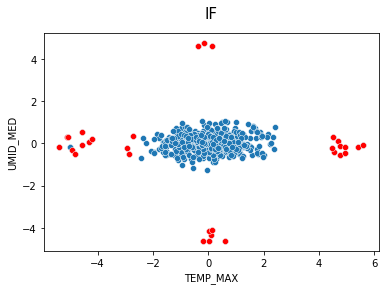

In [90]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns

#x = np.array([[10, 50], [12, 50]], np.float)
#df=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED'])
#df_training_temp = pd.concat([df, df_training_temp]).drop_duplicates(keep=False)

X = np.array(df_training_temp)

iforest = IsolationForest(n_estimators=100, max_samples=df_training_temp.shape[0], 
                          warm_start=False,
                          contamination=0.05, max_features=1.0, 
                          bootstrap=False, n_jobs=None, random_state=None)

pred = iforest.fit_predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

sc=StandardScaler()
X_scaled = sc.fit_transform(X)
outlier_values_scaled = sc.transform(outlier_values)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
outlier_values_pca = pca.transform(outlier_values_scaled)

dfAnomalieIF = pd.DataFrame(outlier_values_scaled, 
             columns=['TEMP_MAX', 
                      'UMID_MED'])
print (df_training_temp)
print (dfAnomalieIF)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
sns.scatterplot(x=outlier_values_pca[:,0], 
                y=outlier_values_pca[:,1], color='r')
plt.title("IF", fontsize=15, pad=15)
plt.xlabel("TEMP_MAX")
plt.ylabel("UMID_MED")

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

X_test = np.array(df_test_temp)
X_train = np.array(df_training_temp)

# fit the model
clf = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma='scale').fit(X_train)
y_pred_train = clf.predict(X_train)
print (y_pred_train)
print ()
y_pred_test = clf.predict(X_test)
print (y_pred_test)

'''
outlier_index = np.where(y_pred_train==-1)
outlier_values = X_train[outlier_index]
print (outlier_values)
'''


[ 1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1 -1
 -1 -1  1 -1  1 -1  1  1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1
 -1  1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1
 -1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1  1 -1  1 -1
  1 -1  1  1  1  1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1  1
 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1 -1
  1  1 -1  1  1  1 -1 -1  1 -1  1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1
  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1
 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1
 -1  1  1 -1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1  1 -1  1
  1 -1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1  1  1  1

'\noutlier_index = np.where(y_pred_train==-1)\noutlier_values = X_train[outlier_index]\nprint (outlier_values)\n'